# Monday, November 18th, 2024

## Returning to Conway's Game of Life

How might we visualize the data generated through Conway's Game of Life?

First, let's borrow code from last week:

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def count_live_neighbors(cells,i,j):
    # Similar to the Image Denoising project, let's build a padded version of cells:
    nrows, ncols = cells.shape   # Get number of rows and columns of cells
    padded_cells = np.zeros((nrows + 2, ncols +2), dtype=int)
    padded_cells[1:-1, 1:-1] = cells      # Inset the cells array inside the padded cells
    
    grid = padded_cells[i:i+3, j:j+3] # Get a 3x3 grid centered on cell i,j from the padded array

    live_neighbors = np.sum(grid) - grid[1,1] # Add the live neighbors (including the cell itself)
                                              # and subtract the cell itself.
        
    return live_neighbors

In [14]:
def update_cells(cells):
    updated_cells = cells.copy()
    
    nrows, ncols = cells.shape
    for i in range(nrows):
        for j in range(ncols):
            live_neighbors = count_live_neighbors(cells,i,j)
            # Rule 1
            if cells[i,j] == 1:  # If the cell is alive:
                if (live_neighbors == 2) or (live_neighbors == 3):
                    updated_cells[i,j] = 1
                else:
                    updated_cells[i,j] = 0
            # Rule 2
            if cells[i,j] == 0: # If the cell is not alive:
                if (live_neighbors == 3):
                    updated_cells[i,j] = 1
                else:
                    updated_cells[i,j] = 0
            # Rule 3
            # If neither of the above rules applied, don't change anything

    return updated_cells

In [15]:
%matplotlib qt
from matplotlib.animation import FuncAnimation

In [16]:
cells = np.zeros((50,50),dtype=int)
live_mask = np.random.random(cells.shape) < 0.4
cells[live_mask] = 1

fig = plt.figure()
im = plt.imshow(cells,vmin=0,vmax=1)               # Generate the initial plot

def animate(i):
    updated_cells = update_cells(cells)        # Get updated cells
    cells[:,:] = updated_cells
    im.set_data(cells)                             # Update the figure with new x array
    return im

anim = FuncAnimation(fig, animate, cache_frame_data=False)
plt.show()

Let's write a function that takes in an initial configuration `cells_0` and an integer `T`, and applies the Game of Life rule's to update `cells_0` `T` times, preserving the entire history of configurations.

In this function:
 - `cells_0` is a 2D array containing the initial configuration
 - `cells` is a 3D dimensional array, where `cells[:,:,k]` is the configuration at time step `k`

In [29]:
%matplotlib inline

In [30]:
def run_game_of_life(cells_0, T):
    nrows, ncols = cells_0.shape
    
    cells = np.zeros((nrows,ncols,T+1))  # Build an array for us to fill with data
    cells[:,:,0] = cells_0               # Set the initial configuration
    
    for k in range(T):
        # We will plug the kth configuration, cells[:,:,k], into `update_cells`
        # and store the result as the (k+1)st configuration, cells[:,:,k+1]
        cells[:,:,k+1] = update_cells(cells[:,:,k])
        
    return cells

In [18]:
cells_0 = np.zeros((50,50),dtype=int)
live_mask = np.random.random(cells_0.shape) < 0.4
cells_0[live_mask] = 1

In [25]:
T = 300

cells = run_game_of_life(cells_0,T)

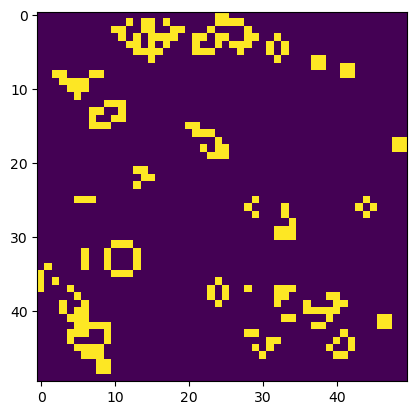

In [31]:
plt.imshow(cells[:,:,100])

We could create a figure with various snapshots as subplots:

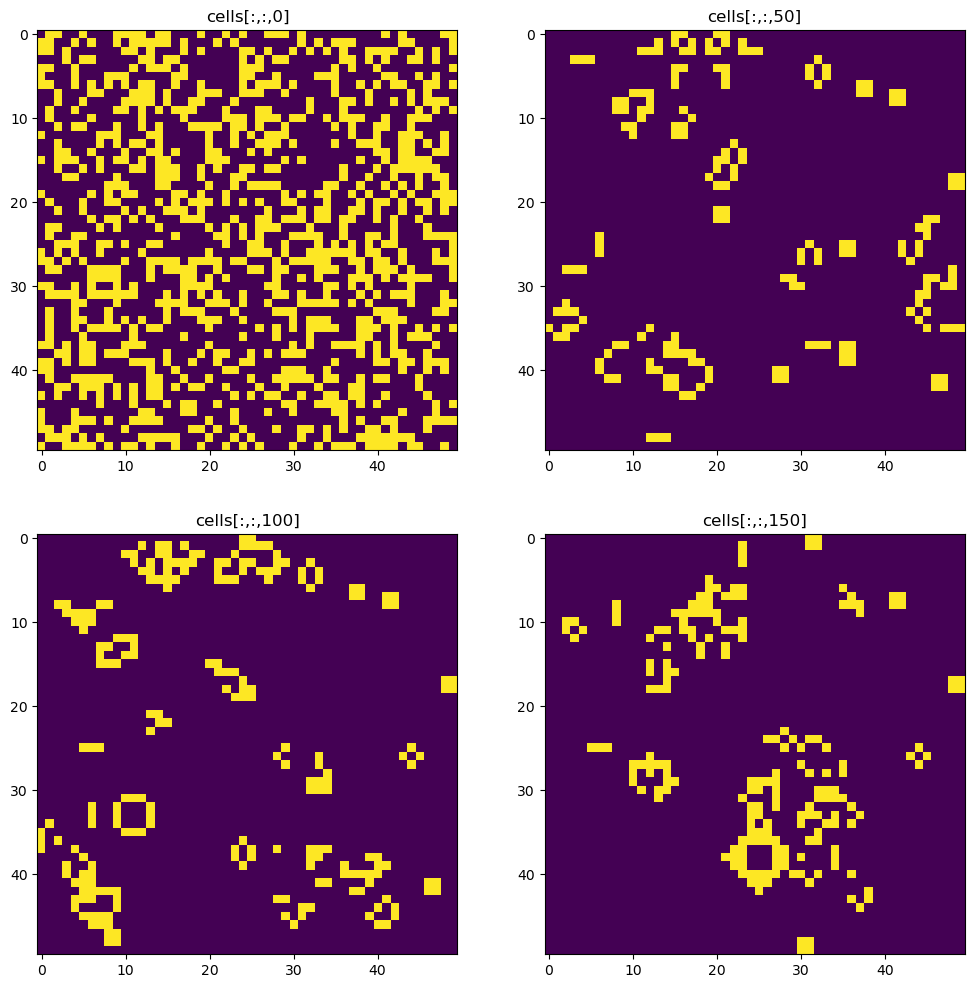

In [32]:
t_list = [0, 50, 100, 150]  # list of time slices we want to see

plt.figure(figsize=(12,12))

for i, t in enumerate(t_list):
    plt.subplot(2,2,i+1)
    
    plt.imshow(cells[:,:,t])
    
    plt.title('cells[:,:,{:}]'.format(t))

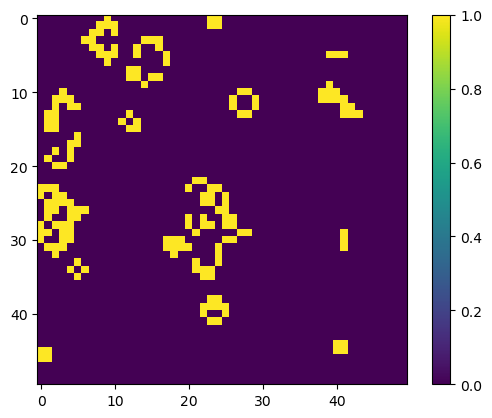

In [71]:
plt.imshow(cells[:,:,100])
plt.colorbar()

Let's try something different. At each time slice, let's count the total number of living cells. We can then plot these counts versus time.

In [33]:
live_cell_counts = []

for t in range(T+1):
    count = (cells[:,:,t] == 1).sum()  # Count how many cells are currently alive
    live_cell_counts.append(count)

Text(0.5, 1.0, 'Cell population through Game of Life')

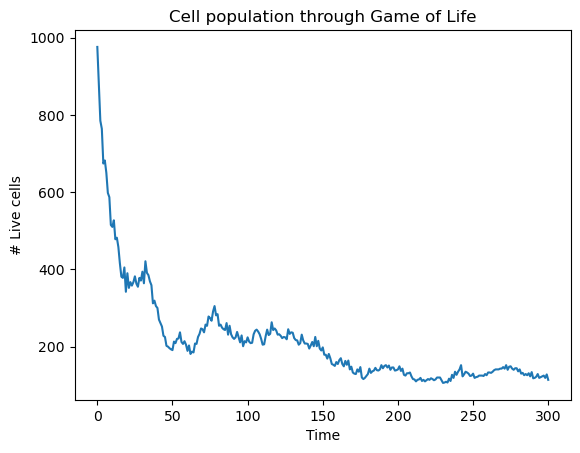

In [34]:
plt.plot(live_cell_counts)

plt.xlabel('Time')
plt.ylabel('# Live cells')
plt.title('Cell population through Game of Life')

Let's run this simulation several times, with different randomly generated initial data, then plot the live cell counts for each run together.

In [35]:
def count_live_cells(cells):
    live_cell_counts = []

    T = cells.shape[2] - 1         # Get the number of time step advancements
    
    for t in range(T+1):
        count = (cells[:,:,t] == 1).sum()  # Count how many cells are currently alive
        live_cell_counts.append(count)
        
    return live_cell_counts

In [37]:
# Set up our runs:

T = 200          # Number of time steps that will be advanced
nrows = 50       # Number of rows in cells
ncols = 50       # Number of columns in cells
prob_live = 0.4  # Probability that a cell is alive in the initial configuration

number_runs = 4

runs = []  # Empty list that will store the cells array for each run

for i in range(number_runs):
    # Setup the initial configuration
    cells_0 = np.zeros((ncols,ncols),dtype=int)
    live_mask = np.random.random(cells_0.shape) < prob_live
    cells_0[live_mask] = 1

    # Run the Game of Life for T time steps
    cells = run_game_of_life(cells_0, T)
    
    runs.append(cells)

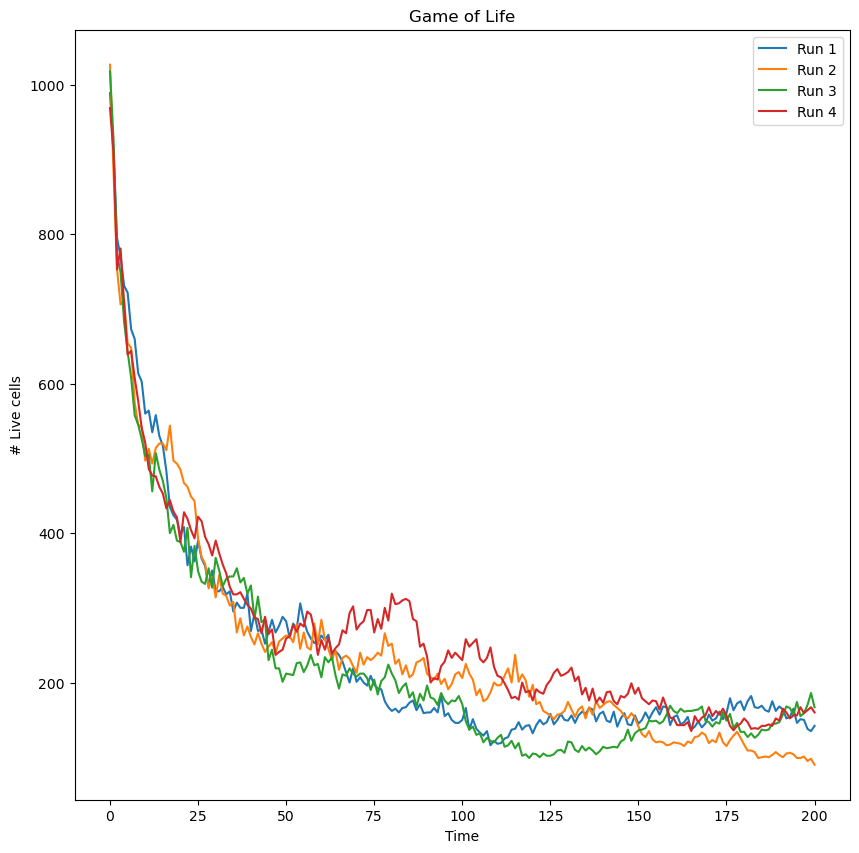

In [39]:
plt.figure(figsize=(10,10))

for i, cells in enumerate(runs):
    live_cell_counts = count_live_cells(cells)
    
    plt.plot(live_cell_counts, label='Run {:}'.format(i+1))
    
plt.xlabel('Time')
plt.ylabel('# Live cells')
plt.title('Game of Life')

plt.legend()

In [40]:
with open('5desk.txt') as f:
    s = f.read()
    
words = s.split()

In [41]:
words[:10]

['A',
 'a',
 'Aachen',
 'Aalborg',
 'aardvark',
 'Aarhus',
 'Aaron',
 'AB',
 'Ab',
 'abaci']

In [42]:
words_set = set(words)

In [48]:
decrypted_words = ['Hello', 'Hello', 'Hello', 'Hello', 'Goodbye', 's;alfkjdas;kljd']
cleaned_words = [word.lower() for word in decrypted_words]

In [49]:
words_set.intersection(cleaned_words)

{'goodbye', 'hello'}

In [50]:
mydict = {'Alpha':5, 'Bravo':3, 'Charlie': -1}

In [51]:
max(mydict)

'Charlie'

In [54]:
max(mydict, key=lambda k: mydict[k])

'Alpha'

In [55]:
mydict.keys()

dict_keys(['Alpha', 'Bravo', 'Charlie'])

In [59]:
ind = np.argmax(mydict.values())

print(list(mydict.keys())[ind])

Alpha


In [63]:
max([(v,k) for k,v in mydict.items()])

(5, 'Alpha')

In [64]:
# Set up our runs:

T = 200          # Number of time steps that will be advanced
nrows = 50       # Number of rows in cells
ncols = 50       # Number of columns in cells
prob_live = 0.4  # Probability that a cell is alive in the initial configuration

number_runs = 40

runs = []  # Empty list that will store the cells array for each run

for i in range(number_runs):
    # Setup the initial configuration
    cells_0 = np.zeros((ncols,ncols),dtype=int)
    live_mask = np.random.random(cells_0.shape) < prob_live
    cells_0[live_mask] = 1

    # Run the Game of Life for T time steps
    cells = run_game_of_life(cells_0, T)
    
    runs.append(cells)

Text(0.5, 1.0, 'Game of Life')

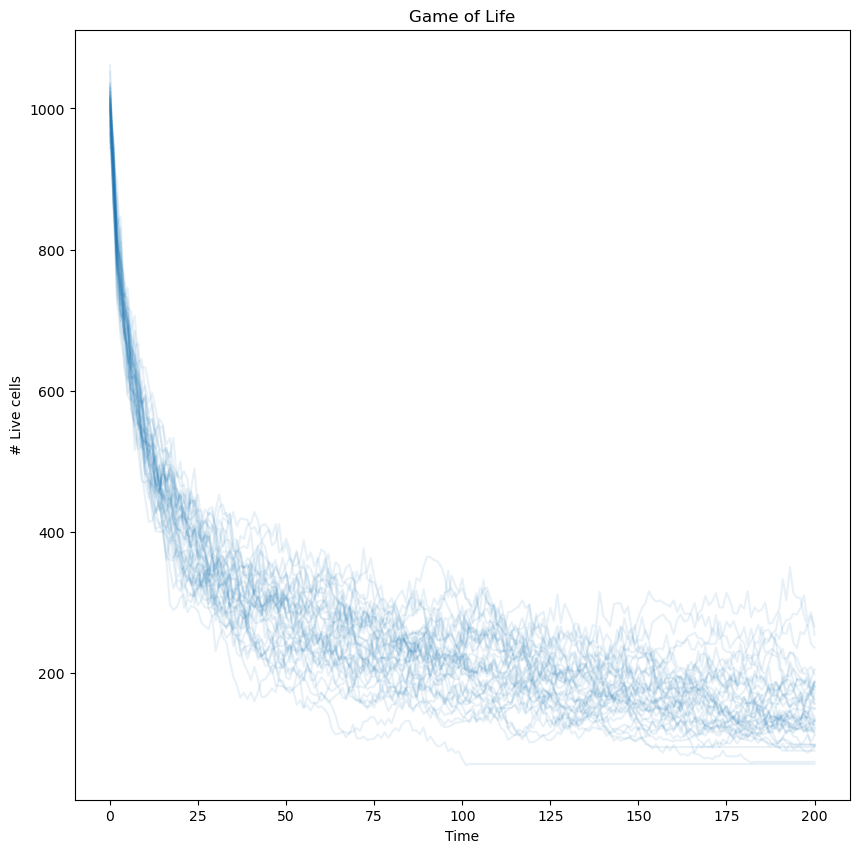

In [74]:
plt.figure(figsize=(10,10))

for i, cells in enumerate(runs):
    live_cell_counts = count_live_cells(cells)
    
    plt.plot(live_cell_counts, color='C0', alpha = .1)
    
plt.xlabel('Time')
plt.ylabel('# Live cells')
plt.title('Game of Life')

# Wednesday, November 20th, 2024

Very often, we may want to use Python to access information from the internet. One way to do this is with the `requests` package.

In [1]:
import requests

In [4]:
#help(requests)

In [5]:
MTH337 = requests.get('https://jllottes.github.io')

The `.headers` attribute gives some information about the nature of the requested webpage:

In [6]:
MTH337.headers

{'Connection': 'keep-alive', 'Content-Length': '5348', 'Server': 'GitHub.com', 'Content-Type': 'text/html; charset=utf-8', 'permissions-policy': 'interest-cohort=()', 'Last-Modified': 'Mon, 18 Nov 2024 20:46:41 GMT', 'Access-Control-Allow-Origin': '*', 'Strict-Transport-Security': 'max-age=31556952', 'ETag': 'W/"673ba7b1-4293"', 'expires': 'Wed, 20 Nov 2024 19:15:12 GMT', 'Cache-Control': 'max-age=600', 'Content-Encoding': 'gzip', 'x-proxy-cache': 'MISS', 'X-GitHub-Request-Id': '9075:2EF32B:E78C46:F947EA:673E32E7', 'Accept-Ranges': 'bytes', 'Date': 'Wed, 20 Nov 2024 20:06:51 GMT', 'Via': '1.1 varnish', 'Age': '597', 'X-Served-By': 'cache-lga21934-LGA', 'X-Cache': 'HIT', 'X-Cache-Hits': '1', 'X-Timer': 'S1732133212.645323,VS0,VE1', 'Vary': 'Accept-Encoding', 'X-Fastly-Request-ID': 'c55a57f589ebb862f9f0479c74f164321ec71eba'}

We can find the text content of the page using the `.text` attribute:

In [15]:
print(MTH337.text[:1000])

<!DOCTYPE html>
<html class="writer-html5" lang="en" data-content_root="./">
<head>
  <meta charset="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" />

  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
  <title>Syllabus &mdash; MTH 337 - Fall 2024  documentation</title>
      <link rel="stylesheet" type="text/css" href="_static/pygments.css?v=80d5e7a1" />
      <link rel="stylesheet" type="text/css" href="_static/css/theme.css?v=19f00094" />
      <link rel="stylesheet" type="text/css" href="_static/copybutton.css?v=76b2166b" />
      <link rel="stylesheet" type="text/css" href="_static/css/custom.css?v=7c08d473" />

  
    <link rel="shortcut icon" href="_static/favicon.ico"/>
    <link rel="canonical" href="https://jllottes.github.io/index.html" />
  <!--[if lt IE 9]>
    <script src="_static/js/html5shiv.min.js"></script>
  <![endif]-->
  
        <script src="_static/jquery.js?v=5d32c60e"></script>
        <script src="_static/

We will use requests to download some sample string data, which we will process using the `re` package, which is short for **Regular Expressions**.

## Regular expressions

The `re` package is a powerful tool for processing strings.

In [16]:
import re

In [66]:
#help(re)

Regular expressions work by providing a "pattern" that we will look for in a string.

In [19]:
my_string = 'Hello, my name is Jon. Today is Wednesday, November 20th, 2024.'

In [20]:
pattern = r'is'

re.findall(pattern, my_string)

['is', 'is']

In [21]:
help(re.sub)

Help on function sub in module re:

sub(pattern, repl, string, count=0, flags=0)
    Return the string obtained by replacing the leftmost
    non-overlapping occurrences of the pattern in string by the
    replacement repl.  repl can be either a string or a callable;
    if a string, backslash escapes in it are processed.  If it is
    a callable, it's passed the Match object and must return
    a replacement string to be used.



In [22]:
re.sub(pattern, "isn't", my_string)

"Hello, my name isn't Jon. Today isn't Wednesday, November 20th, 2024."

This works the same as `my_string.replace('is',"isn't")`:

In [23]:
my_string.replace('is',"isn't")

"Hello, my name isn't Jon. Today isn't Wednesday, November 20th, 2024."

With regular expressions, we can use more flexible patterns.

 - `\w` refers to any word character (meaning A-Z, a-z, 0-9, and \_)

In [24]:
print(my_string)

Hello, my name is Jon. Today is Wednesday, November 20th, 2024.


In [25]:
pattern = r'n\w'

re.findall(pattern, my_string)

['na', 'ne']

If we want to be more flexible about the number of occurences of some character, we can use
 - `*` checks any number of matches (0 or more)
 - `+` checks for one or more matches

In [26]:
pattern = r'n\w+'
re.findall(pattern, my_string)

['name', 'nesday']

In [27]:
pattern = r'n\w*'
re.findall(pattern, my_string)

['name', 'n', 'nesday']

Other special characters:
 - `\b` refers to any boundary character, i.e. the start or end of a word
 - `\s` refers to any whitespace character
 - `\d` refers to any number (0-9)

In [29]:
pattern = r'\d+'

re.findall(pattern, my_string)

['20', '2024']

In [47]:
print(r'\t')

\t


## Tip/warning: when building regular expression patterns, always use raw strings.

Example: 
 - `r'this is a raw string'`
 - `'this is a normal string'`

We can use parentheses to specify which parts of the pattern we want to actually return.

In [37]:
pattern = r'my name is (\w+)\s*(\w+){,1}'

re.findall(pattern, my_string)

[('Jon', '')]

In [38]:
my_string2 = r'Hello, my name is Jon Lottes. Today is Wednesday, November 20th, 2024.'

In [39]:
re.findall(pattern, my_string2)

[('Jon', 'Lottes')]

We can create sets of characters in our patterns using square brackets:

In [50]:
pattern = r'\bn\w*'

re.findall(pattern, my_string)

['name']

In [51]:
pattern = r'\bN\w*'

re.findall(pattern, my_string)

['November']

In [52]:
pattern = r'\b[nN]\w*'

re.findall(pattern, my_string)

['name', 'November']

We can use hyphens to denote a range of characters. For example `[A-Z]` would match any capital letter:

In [53]:
pattern = r'\b[A-Z]\w*'

re.findall(pattern, my_string)

['Hello', 'Jon', 'Today', 'Wednesday', 'November']

Let's use `requests` to get some more interesting string data. In particular, let's get some data from Project Gutenberg.

In [54]:
pure_design = requests.get('https://www.gutenberg.org/cache/epub/74765/pg74765.txt')

In [55]:
text = pure_design.text

In [56]:
print(text[:1000])

﻿The Project Gutenberg eBook of A theory of pure design: harmony, balance, rhythm
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: A theory of pure design: harmony, balance, rhythm

Author: Denman W. Ross

Release date: November 20, 2024 [eBook #74765]

Language: English

Original publication: United States: Houghton, Mifflin & Co

Credits: Tim Lindell and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by The Internet Archive/Canadian Libraries)


*** START OF THE PROJECT GUTENBERG EBO


Let's use regular expressions to find some strings inside this eBook.

Let's find all words that start with "z" (capital or lowercase).

In [59]:
pattern = r'\b[zZ]\w*'

re.findall(pattern, text)

['zero', 'zero', 'zero', 'zero']

In [62]:
pattern = r'20\d{2}'

re.findall(pattern, text)

['2024', '2001']

In [65]:
pattern = r'\d+'

print(re.sub(pattern, '123456789', text)[:2000])

﻿The Project Gutenberg eBook of A theory of pure design: harmony, balance, rhythm
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: A theory of pure design: harmony, balance, rhythm

Author: Denman W. Ross

Release date: November 123456789, 123456789 [eBook #123456789]

Language: English

Original publication: United States: Houghton, Mifflin & Co

Credits: Tim Lindell and the Online Distributed Proofreading Team at https://www.pgdp.net (This file was produced from images generously made available by The Internet Archive/Canadian Libraries)


*** START OF THE PROJECT GUTENBERG EBOOK A TH